# Tutorial demonstrating the basic functionality of the `iwaves` package

In this tutorial we will learn how to:

 - Download the data netcdf4 file
 - Inspect the data
 - Plot a variable
 - Interpolate a scalar onto a point
 - Extract a time-series of internal tide sea surface height amplitude at a point
 - Extract the stratification at a point
 
---

 

In [1]:
# These are the sub-modules in the iwatlas package that we will use
from iwatlas import sshdriver
from iwatlas import harmonics
from iwatlas import stratification as strat
from iwatlas import iwaves

import xarray as xr
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt

In [2]:
# Uncomment this option to allow for interactive plot windows (e.g. zooming)
# %matplotlib notebook

In [3]:
# Download the data if it does not exist
import urllib, os

# Link to a 200 MB data file on cloudstor
publicurl = 'https://cloudstor.aarnet.edu.au/plus/s/vdksw5WKFOTO0nD/download'

basedir = '../DATA'
atlasfile = '{}/NWS_2km_GLORYS_hex_2013_2014_InternalWave_Atlas.nc'.format(basedir)

if os.path.exists(basedir):
    print('Folder exists.')
else:
    print('Making folder {}'.format(basedir))
    os.mkdir(basedir)
    
if os.path.exists(atlasfile):
    print('File exists.')
else:
    print('Downloading file...')
    urllib.request.urlretrieve (publicurl, atlasfile)
    print('Done. Saved to {}'.format(N2file))


Folder exists.
File exists.


# Example 1: Open the dataset 

For this we will use the function `sshdriver.load_ssh_clim` method. This method wraps the `sfoda.ugrid.sunxray.Sunxray` class that is basically an unstructured grid `xarray.Dataset` object.

In [4]:
ssh = sshdriver.load_ssh_clim(atlasfile)
ssh

<xarray.Dataset>
Dimensions:     (Nannual: 4, Nc: 225368, Nk: 80, Nkw: 81, Nmode: 4, Np: 454016, Nparams: 7, Ntide: 35, numsides: 8)
Coordinates:
    xv          (Nc) float64 ...
    yv          (Nc) float64 ...
    Nk          (Nc) int32 ...
    z_w         (Nkw) float64 ...
    omegaA      (Nannual) float64 ...
    params      (Nparams) int64 ...
    omega       (Ntide) float64 ...
Dimensions without coordinates: Nannual, Nc, Nkw, Nmode, Np, Nparams, Ntide, numsides
Data variables:
    cells       (Nc, numsides) int32 3058 3061 3060 2801 ... 316184 316187 -1 -1
    xp          (Np) float64 1.394e+07 1.271e+07 ... 1.303e+07 1.303e+07
    yp          (Np) float64 -1.619e+06 -2.553e+06 ... -2.056e+06 -2.055e+06
    nfaces      (Nc) int32 ...
    dv          (Nc) float64 ...
    modes       (Nmode) float64 ...
    dz          (Nk) float64 ...
    z_r         (Nk) float64 ...
    N2_mu       (Nparams, Nc) float64 ...
    N2_re       (Nannual, Nparams, Nc) float64 ...
    N2_im       (Nann

We can see from the printout above the *coordinate* and *data variables* plus some *global attributes*. Many of the coordinate and data variables are associated with the unstructured grid topology (e.g., $xv$, $cells$, $nfaces$). The data variables of interest are stored as follows:

 - Sea surface height harmonics: `SSH_BC_*`
 - Stratification variables: `N2_*`
 

# Example 2: Inspect an individual variable

The `xarray.Dataset` class is the `._ds` attribute. To access a variable (an `xarray.DataArray` object) we call `ssh._ds[varname]`.

In [5]:
ssh._ds['SSH_BC_var']

<xarray.DataArray 'SSH_BC_var' (Nc: 225368)>
[225368 values with dtype=float64]
Coordinates:
    xv       (Nc) float64 ...
    yv       (Nc) float64 ...
    Nk       (Nc) int32 ...
Dimensions without coordinates: Nc
Attributes:
    long_name:  SSH_BC - signal variance
    units:      m^2

# Example 3: Plot a spatial variable

The data is on an unstructured grid so we call either `plotcelldata` or `contourf` methods in the object.

In [6]:
# To show help for a method within an object use the ? symbol e.g.,
ssh.plotcelldata?

Signature:
ssh.plotcelldata(
    z,
    xlims=None,
    ylims=None,
    colorbar=True,
    vmin=None,
    vmax=None,
    **kwargs,
)
Docstring: Plot cell centered data
File:      ~/code/sfoda/sfoda/ugrid/uplot.py
Type:      method


Text(0.5, 1.0, 'SSH_BC - signal variance')

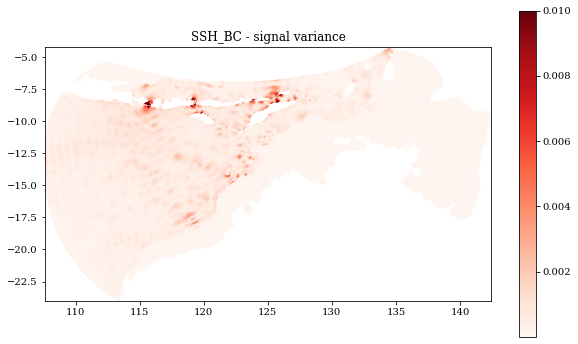

In [7]:
# Plot the Sea surface height signal variance
plt.figure(figsize=(10,6))
ssh.plotcelldata(ssh._ds['SSH_BC_var'], vmax=1e-2, cmap='Reds')
plt.title(ssh._ds['SSH_BC_var'].attrs['long_name'])

This is nice but it is hard to see any landmarks. Let's add some bathymetry contours...

Text(0.5, 1.0, 'SSH_BC - signal variance')

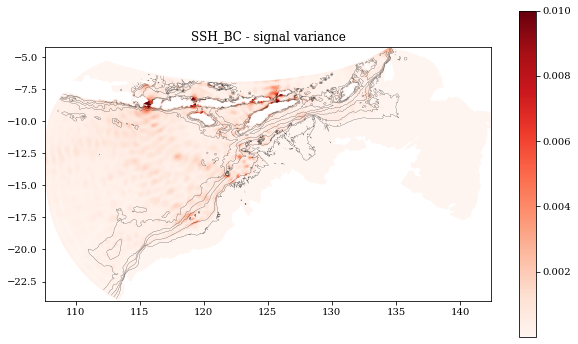

In [8]:
plt.figure(figsize=(10,6))
ssh.plotcelldata(ssh._ds['SSH_BC_var'], vmax=1e-2, cmap='Reds')
ssh.contourf(ssh._ds['dv'], [100, 200,  500, 1000, 2000], colors='k', linewidths=0.2, filled=False, colorbar=False)
plt.title(ssh._ds['SSH_BC_var'].attrs['long_name'])

# Example 4: Interpolate a scalar onto a point

The `sunxray` object has a convenient `.interpolate` method to extract a scalar from the unstructured grid.


In [10]:
# WA-IMOS locations (August 2019)
sites = {
'NIN100':{'y':-21.84986667,'x':113.9064667},
'NWSBAR':{'y':-20.76128333,'x':114.7586167},
'NWSROW':{'y':-17.75801667,'x':119.9061},
'NWSBRW':{'y':-14.23543333,'x':123.1623833},
'NWSLYN':{'y':-9.939416667,'x':130.3490833},
'PIL200':{'x': 115.9154, 'y':-19.435333}   ,
'KIM200':{'x':121.243217 , 'y':-15.534517} ,  
'KIM400':{'x': 121.114967, 'y':-15.22125}   ,
'ITFTIS':{'x': 127.5577, 'y':-9.819217}   ,
'BB250':{'x':123.34613 , 'y':-13.75897}  ,
'Prelude':{'x':123.3506, 'y':-13.7641} , 
}

In [11]:
# Spatial coordinates of point
sitename = 'ITFTIS'
xpt = sites[sitename]['x']
ypt = sites[sitename]['y']

# Call to the interpolation method
mydata = ssh.interpolate(ssh._ds['SSH_BC_var'], xpt, ypt)

print('The SSH variance at X: {} Y: {} is {}'.format(\
                    xpt, ypt, mydata ) )

The SSH variance at X: 127.5577 Y: -9.819217 is 0.0014409232890107149


# Example 5: Extract a time-series of baroclinic sea surface height anomaly

To do this we use the driver functions in the `iwatlas.sshdriver` submodule. In particular the `predict_ssh` method



In [12]:
sshdriver.predict_ssh?

Signature: sshdriver.predict_ssh(sshfile, x, y, time, kind='linear')
Docstring: Perform harmonic predictions at the points in x and y
File:      ~/code/iwatlas/iwatlas/sshdriver.py
Type:      function


Text(0, 0.5, '$SSH_{BC}$ [m]')

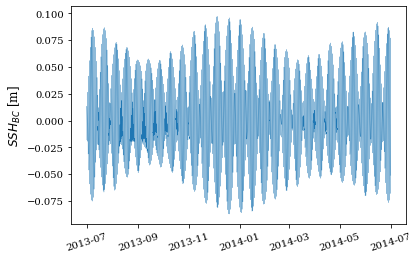

In [42]:
# Create a time vector
dt = 1800
numdays = 365
tstart = np.datetime64('2013-07-01 00:00:00')


nsteps = numdays*86400//dt
timeout = np.array([tstart+np.timedelta64(ii*dt,'s') for ii in range(nsteps)])

# Call the prediction funciton
ssh_ts = sshdriver.predict_ssh(atlasfile, xpt, ypt, timeout)

# Plot the time series
plt.figure()
plt.plot(timeout, ssh_ts, lw=0.25)
plt.xticks(rotation=17)
plt.ylabel('$SSH_{BC}$ [m]')

Maybe we also want to look at the contributions from the individual harmonics to this signal and how they vary. To do this use the `extract_amp_nonstat` function.

This outputs two arrays, the real and imaginary amplitude, for each harmonic

Text(0, 0.5, '$SSH_{BC}$ [m]')

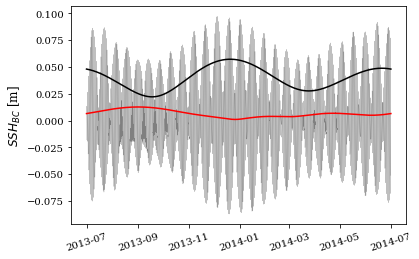

In [61]:
ssh_ns_re, ssh_ns_im = sshdriver.extract_amp_nonstat(ssh, np.array([xpt]), np.array([ypt]), timeout)

# To plot the amplitude of the first harmonic (M2) use the
plt.figure()
plt.plot(timeout, ssh_ts, '0.5', lw=0.25)
plt.plot(timeout, np.abs(ssh_ns_re[0,...] + 1j*ssh_ns_im[0,...]), 'r', ) # M2
plt.plot(timeout, np.abs(ssh_ns_re[3,...] + 1j*ssh_ns_im[3,...]), 'k', ) # K1


plt.xticks(rotation=17)
plt.ylabel('$SSH_{BC}$ [m]')


# Example: Extract the density stratification at a point

Use the `iwatlas.stratification` module to extract density (buoyancy frequency) profile

In [44]:
strat.predict_N2?

Signature: strat.predict_N2(N2file, xpt, ypt, timept, nz, density_func=None, **kwargs)
Docstring:
Return a buoyancy frequency squared (N^2) vertical profile at a space-time location of choice

Inputs:
---
    N2file: filename of the stratification climatology dataset (NWS_2km_GLORYS_hex_2013_2014_Stratification_Atlas.nc)
    xpy,ypt: vectors [nx] of output space points
    timept: vector [nt] of datetime64 time objects
    nz: scalar with number of sigma layers

Returns:
    N2_z: array of buoyancy frequency [nz, nx, nt]
File:      ~/code/iwatlas/iwatlas/stratification.py
Type:      function


In [49]:
# 
nz = 80 # Number of vertical layers to output

# Call the predict_N2 method. Note that this function expects numpy arrays, not scalars, for all inputs

N2_z, zout = strat.predict_N2(atlasfile, np.array([xpt]), np.array([ypt]), timeout, nz)


/home/suntans/code/iwatlas/iwatlas/stratification.py:94: RuntimeWarning: divide by zero encountered in log
  zpr = -np.log(zout)


In [78]:
# Convert N^2 to units of cycles per day
cpd = 2*np.pi/86400.
N_cpd = np.sqrt(N2_z)/cpd
86400/600.

144.0

Text(0.5, 0, '$N$ [cpd]')

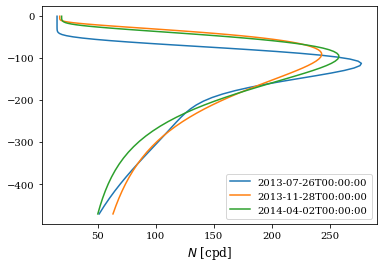

In [81]:
plt.figure()
plt.plot(N_cpd[:,0,1200], -zout[:,0,0], )
plt.plot(N_cpd[:,0,7200], -zout[:,0,7200], )
plt.plot(N_cpd[:,0,13200], -zout[:,0,13200], )

plt.legend(timeout[[1200,7200,13200]])
plt.xlabel('$N$ [cpd]')

In [58]:
# Calculate the internal wave parameters
mode= 0 

# Mode shapes
phi_n, cn = iwaves.calc_modes(N2_z, zout, mode=mode)

# KdV nonlinearity parameter
alpha = iwaves.calc_alpha(phi_n, cn, zout)

# KdV dispersion parameter
beta = iwaves.calc_beta(phi_n, cn, zout)

# Factor to convert SSH to isotherm displacement amplitude
sshratio = iwaves.amp_to_ssh_ratio(N2_z, phi_n, zout)
print(cn[0,0], alpha[0,0], beta[0,0], sshratio[0,0])

1.788061038777452 -0.0105515365864904 17595.70334084629 240.04799377298588


# Example: convert SSH prediction to isotherm displacement amplitude


Text(0, 0.5, 'Displacement Amp. [m]')

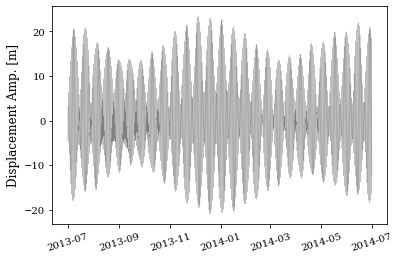

In [82]:
# This is simply the sshratio multiplied by the SSH
amp_ts = ssh_ts*sshratio[0,0]
plt.figure()
plt.plot(timeout, amp_ts, '0.5', lw=0.25)
plt.xticks(rotation=17)
plt.ylabel('Displacement Amp. [m]')